In [1]:
import numpy as np
import tensorflow as tf
from enum import Enum
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d

In [2]:
with open('data/batch1.pkl', 'rb') as f:
    batch1 = np.load(f)
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

with open('data/batch2.pkl', 'rb') as f:
    batch2 = np.load(f)
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

with open('data/batch3.pkl', 'rb') as f:
    batch3 = np.load(f)
    
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

batch1_size = len(batch1.keys())
batch2_size = len(batch2.keys())
batch3_size = len(batch3.keys())

batch_size = batch1_size + batch2_size + batch3_size

batches = {**batch1, **batch2, **batch3}

del batch1
del batch2
del batch3

In [3]:
test_ind = np.hstack((np.arange(0,(batch1_size+batch2_size),2),83))
train_ind = np.arange(1,(batch1_size+batch2_size-1),2)
secondary_test_ind = np.arange(batch_size-batch3_size,batch_size)

Text(0,0.5,'Discharge Capacity (Ah)')

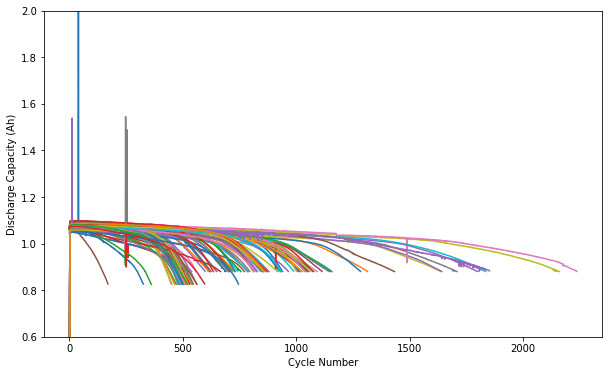

In [4]:
plt.figure(figsize=(10,6))
for i in batches.keys():
    plt.plot(batches[i]['summary']['cycle'], batches[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylim(0.6, 2)
plt.ylabel('Discharge Capacity (Ah)')

In [5]:
print('Cell count: ', len(batches))
print('Cell names: ', batches.keys())

cell = batches['b1c23']

Cell count:  124
Cell names:  dict_keys(['b3c44', 'b3c17', 'b2c31', 'b2c5', 'b3c0', 'b2c1', 'b3c43', 'b1c36', 'b3c24', 'b1c28', 'b2c24', 'b1c32', 'b1c20', 'b2c30', 'b1c25', 'b1c9', 'b2c38', 'b1c35', 'b2c13', 'b1c27', 'b1c38', 'b3c4', 'b1c37', 'b1c14', 'b3c18', 'b3c21', 'b3c28', 'b1c4', 'b2c40', 'b3c36', 'b2c0', 'b2c45', 'b3c10', 'b2c18', 'b1c45', 'b3c41', 'b3c8', 'b1c42', 'b1c29', 'b1c34', 'b3c31', 'b1c44', 'b2c4', 'b2c6', 'b1c43', 'b3c3', 'b2c17', 'b1c26', 'b2c34', 'b2c11', 'b2c19', 'b2c33', 'b2c32', 'b2c20', 'b1c40', 'b1c19', 'b1c21', 'b2c46', 'b3c16', 'b3c25', 'b3c33', 'b2c2', 'b2c27', 'b1c31', 'b3c42', 'b2c35', 'b3c35', 'b3c40', 'b2c41', 'b3c15', 'b3c12', 'b1c24', 'b2c37', 'b1c5', 'b3c5', 'b1c3', 'b2c14', 'b2c25', 'b1c1', 'b3c34', 'b1c23', 'b2c22', 'b2c3', 'b3c6', 'b2c36', 'b1c41', 'b1c2', 'b2c12', 'b3c1', 'b1c11', 'b1c18', 'b3c29', 'b1c33', 'b1c6', 'b3c14', 'b2c23', 'b2c42', 'b2c28', 'b3c22', 'b2c43', 'b2c39', 'b3c26', 'b1c15', 'b1c7', 'b3c45', 'b3c20', 'b3c9', 'b3c27', 'b2c29', '

In [6]:
summary = batches['b1c41']['summary']
summary_keys = summary.keys()
print('keys:', summary_keys)

keys: dict_keys(['cycle', 'chargetime', 'Tmin', 'QC', 'Tavg', 'Tmax', 'QD', 'IR'])


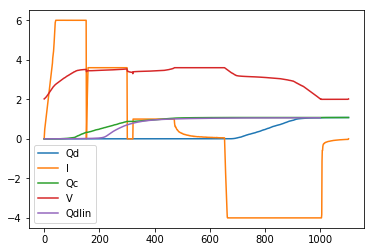

In [7]:
Qd = cell['cycles']['1']['Qd']
I = cell['cycles']['1']['I']
s = slice(len(Qd))


plt.plot(Qd[s], label='Qd')
plt.plot(I[s], label='I')
plt.plot(cell['cycles']['1']['Qc'][s], label='Qc')
plt.plot(cell['cycles']['1']['V'][s], label='V')
plt.plot(cell['cycles']['1']['Qdlin'][s], label='Qdlin')
plt.legend()

In [8]:
def get_QV(cycle, num=1000):
    V = cycle['V']
    Qd = cycle['Qdlin']
    v = np.linspace(np.max(V), np.min(V), num=len(Qd), endpoint=True)
    return Qd, v

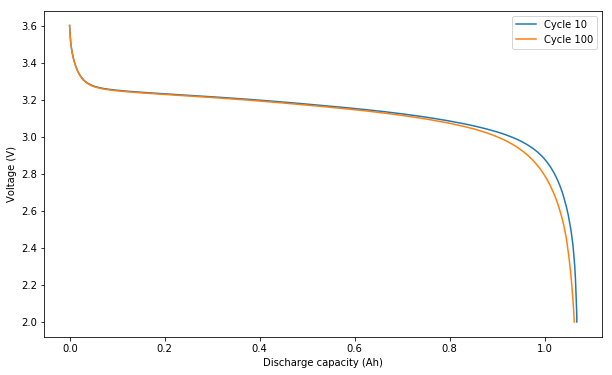

In [9]:
plt.figure(figsize=(10,6))

for cycle in [10, 100]:
    qd, v = get_QV(cell['cycles'][str(cycle)])
    plt.plot(qd, v, label='Cycle {}'.format(cycle))
    plt.xlabel('Discharge capacity (Ah)')
    plt.ylabel('Voltage (V)')
plt.legend()

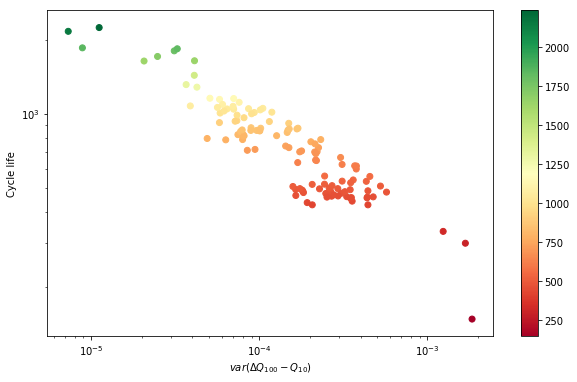

p corr:  -0.9124174890598449


In [10]:
xs, ys = [], []

fig = plt.figure(figsize=(10,6))

for cell in batches.values():
    qv10, v = get_QV(cell['cycles'][str(10)])
    qv100, v = get_QV(cell['cycles'][str(100)])
    var = np.var(qv100 - qv10)

    xs.append(var)
    ys.append(cell['cycle_life'][:])

xs = np.array(xs).reshape(-1, 1)
ys = np.array(ys).reshape(-1, 1)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

cm = plt.cm.get_cmap('RdYlGn')

sc = plt.scatter(xs, ys, c=ys, cmap=cm)
    
plt.colorbar(sc)
plt.ylabel('Cycle life')
plt.xlabel(r'$var(\Delta Q_{100} - Q_{10})$')
plt.show()

xs = np.array(xs).reshape(-1)
ys = np.array(ys).reshape(-1)
print('p corr: ', np.corrcoef(np.log(xs), np.log(ys))[0,1])

In [11]:
# How many cycles to look at?
n_cycles = 100
n_inputs = 1000

N_EPOCHS = 1000

In [12]:
class ModelType(Enum):
    VARIANCE = 0
    DISCHARGE = 1
    FULL = 2

In [13]:
def get_dataset(d, model_type, n_cycles, n_inputs):
    
    if model_type == ModelType.DISCHARGE:
        keys = ['Qd']
        n_features = len(keys)
    elif model_type == ModelType.FULL:
        keys = next(iter(d.values()))['cycles']['0'].keys()
        n_features = len(keys)
    else:
        n_features = 1

    cycle_lives = [cell['cycle_life'].flatten() for cell in d.values()]
    data = None
    variances = np.empty(shape=(len(d), 1))
    for idx, (name, cell) in enumerate(d.items()):
        
        if model_type == ModelType.VARIANCE:
            features = np.empty(shape=(1,), dtype=np.float32)
        else:
            features = np.zeros(shape=(n_cycles, n_features+1, n_inputs), dtype=np.float32)
            for i in range(n_cycles):
                cycle = cell['cycles'][str(i)]
                for j, key in enumerate(keys):
                    choice = np.linspace(0, num=n_inputs, stop=len(values), endpoint=False, dtype=np.int64)
                    values = cycle[key]
                    values = values[choice]
                    features[i,j+1,:] = values
                    
        qd10, v = get_QV(cell['cycles'][str(10)])
        qd100, v = get_QV(cell['cycles'][str(100)])
        q_var = np.log(np.var(qd100 - qd10))
        features[-1] = q_var

        y = cell['cycle_life'].squeeze()
        xy = [features, y]
        if data is None:
            data = xy
        else:
            data = np.vstack([data, xy])
    return data

model_type = ModelType.VARIANCE
data = get_dataset(batches, model_type, n_cycles, n_inputs)

data_train = data[train_ind]
data_val = data[test_ind]
data_test = data[secondary_test_ind]

for x, y in data_train:
    print('x; ', x)
    print('y: ', y)
    break
print('data_train: ', data_train[0])

x;  [-10.21142]
y:  1315.0
data_train:  [array([-10.21142], dtype=float32) array(1315.)]


In [14]:
'''
Just a simple linear MLP.
'''
class BaselineModel(Model):
    def __init__(self, n_inputs, n_layers=3, n_neurons=32):
        super(BaselineModel, self).__init__()
        
        l1reg = 0.8
        l2reg = (1.0-l1reg)/2
    
        lambda_ = 1e-2
        l1reg *= lambda_
        l2reg *= lambda_
        
        layers = []
        layers.append(Dense(n_neurons, activation='relu', input_shape=(1,),
                      kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        for _ in range(n_layers-1):
            layers.append(Dense(n_neurons, activation='relu',
                                kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        self.hidden_layers = layers
        self.out = Dense(1)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.out(x)

model = BaselineModel(n_inputs)

In [15]:
loss_fn = tf.keras.losses.MeanSquaredError()
lr = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=lr/(N_EPOCHS))

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
train_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='train_mape')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='test_mape')

In [16]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
                
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    train_loss(loss)
    train_mse(y, predictions)
    train_mape(y, predictions)

In [17]:
@tf.function
def test_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
  
    test_loss(loss)
    test_mse(y, predictions)
    test_mape(y, predictions)

Epoch 10
Loss: 109484.9453125, RMSE: 330.8851013183594, Mean absolute % error: 40.341087341308594
Test loss: 129371.078125, RMSE: 359.6819152832031, Mean absolute % error: 28.821680068969727


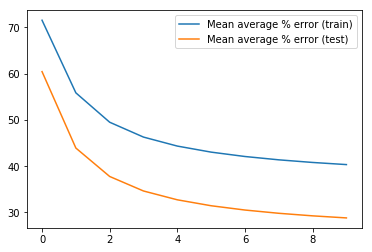

Epoch 20
Loss: 90167.1796875, RMSE: 300.27850341796875, Mean absolute % error: 38.062808990478516
Test loss: 124908.9921875, RMSE: 353.4246520996094, Mean absolute % error: 26.67190933227539


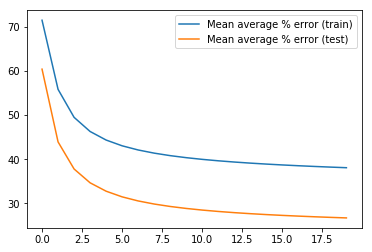

Epoch 30
Loss: 82754.8515625, RMSE: 287.6714172363281, Mean absolute % error: 37.025787353515625
Test loss: 121898.3984375, RMSE: 349.1395263671875, Mean absolute % error: 25.791990280151367


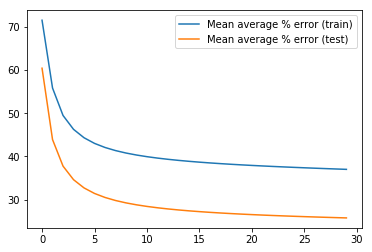

Epoch 40
Loss: 78128.7109375, RMSE: 279.51513671875, Mean absolute % error: 36.237186431884766
Test loss: 118744.8125, RMSE: 344.59368896484375, Mean absolute % error: 25.220605850219727


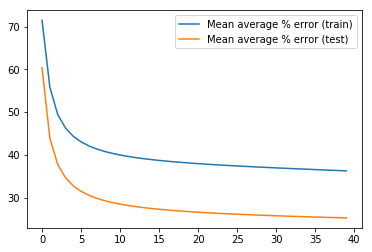

Epoch 50
Loss: 74326.140625, RMSE: 272.6282043457031, Mean absolute % error: 35.45258331298828
Test loss: 114821.6953125, RMSE: 338.853515625, Mean absolute % error: 24.79505157470703


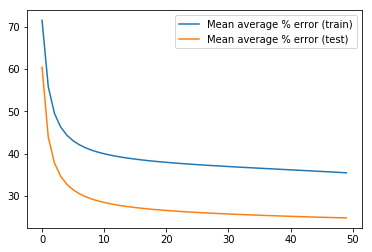

Epoch 60
Loss: 70474.2265625, RMSE: 265.4698181152344, Mean absolute % error: 34.500938415527344
Test loss: 109626.9296875, RMSE: 331.0995788574219, Mean absolute % error: 24.6097469329834


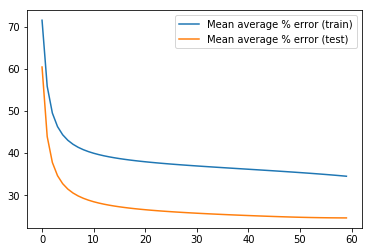

Epoch 70
Loss: 66089.1015625, RMSE: 257.0780029296875, Mean absolute % error: 33.19807434082031
Test loss: 103136.6484375, RMSE: 321.1489562988281, Mean absolute % error: 24.497108459472656


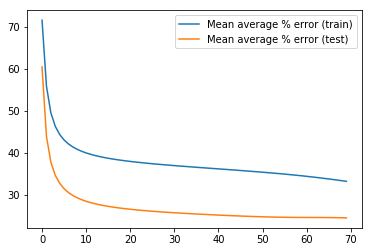

Epoch 80
Loss: 61623.53125, RMSE: 248.24087524414062, Mean absolute % error: 31.594987869262695
Test loss: 95759.1015625, RMSE: 309.4496765136719, Mean absolute % error: 23.743661880493164


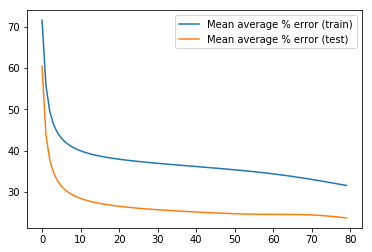

Epoch 90
Loss: 57889.16796875, RMSE: 240.6016845703125, Mean absolute % error: 30.167190551757812
Test loss: 89121.9921875, RMSE: 298.5330810546875, Mean absolute % error: 22.77452278137207


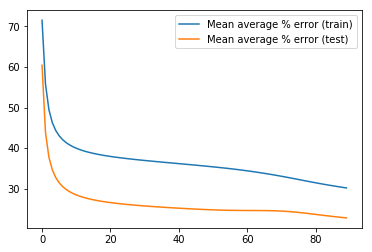

Epoch 100
Loss: 54816.95703125, RMSE: 234.13021850585938, Mean absolute % error: 29.01043701171875
Test loss: 83647.375, RMSE: 289.21856689453125, Mean absolute % error: 21.999317169189453


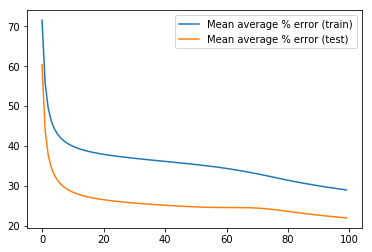

Epoch 110
Loss: 52270.72265625, RMSE: 228.62791442871094, Mean absolute % error: 28.057600021362305
Test loss: 79139.8671875, RMSE: 281.3180847167969, Mean absolute % error: 21.35589027404785


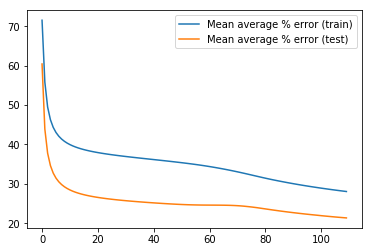

Epoch 120
Loss: 50131.875, RMSE: 223.9014892578125, Mean absolute % error: 27.250736236572266
Test loss: 75343.921875, RMSE: 274.48846435546875, Mean absolute % error: 20.819835662841797


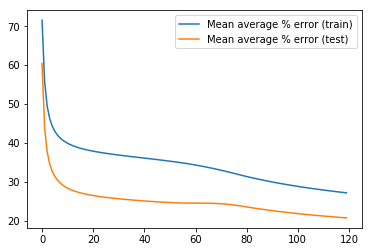

Epoch 130
Loss: 48301.3046875, RMSE: 219.77557373046875, Mean absolute % error: 26.55302619934082
Test loss: 72118.4921875, RMSE: 268.5488586425781, Mean absolute % error: 20.358278274536133


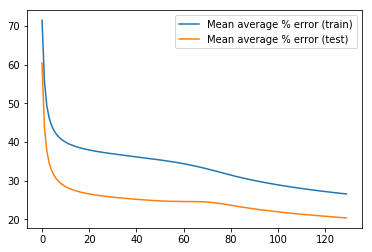

Epoch 140
Loss: 46725.50390625, RMSE: 216.16082763671875, Mean absolute % error: 25.951257705688477
Test loss: 69372.40625, RMSE: 263.38641357421875, Mean absolute % error: 19.97650718688965


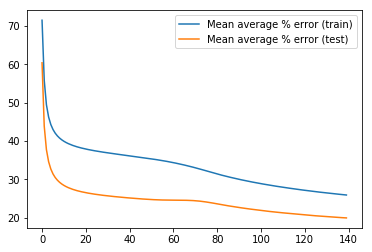

Epoch 150
Loss: 45371.36328125, RMSE: 213.00555419921875, Mean absolute % error: 25.443681716918945
Test loss: 67020.9609375, RMSE: 258.8840637207031, Mean absolute % error: 19.656564712524414


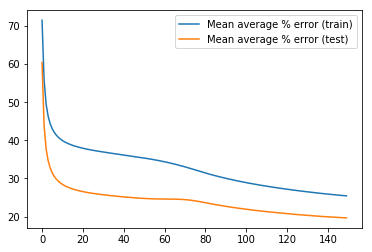

Epoch 160
Loss: 44187.54296875, RMSE: 210.2083282470703, Mean absolute % error: 25.008333206176758
Test loss: 64902.37890625, RMSE: 254.75946044921875, Mean absolute % error: 19.396535873413086


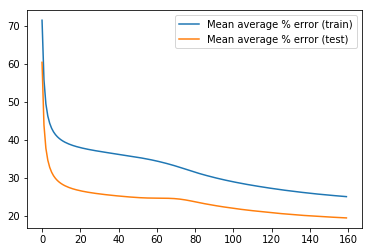

Epoch 170
Loss: 43133.77734375, RMSE: 207.6867218017578, Mean absolute % error: 24.62144660949707
Test loss: 63042.14453125, RMSE: 251.0819549560547, Mean absolute % error: 19.166889190673828


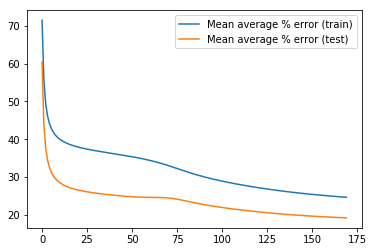

Epoch 180
Loss: 42200.2734375, RMSE: 205.4270477294922, Mean absolute % error: 24.287246704101562
Test loss: 61390.6015625, RMSE: 247.77127075195312, Mean absolute % error: 18.952713012695312


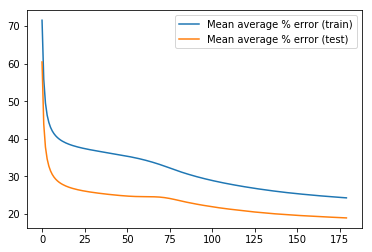

Epoch 190
Loss: 41355.62890625, RMSE: 203.36083984375, Mean absolute % error: 23.987897872924805
Test loss: 59901.22265625, RMSE: 244.7472686767578, Mean absolute % error: 18.760425567626953


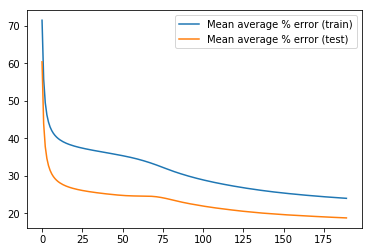

Epoch 200
Loss: 40594.0625, RMSE: 201.47967529296875, Mean absolute % error: 23.718406677246094
Test loss: 58598.13671875, RMSE: 242.07052612304688, Mean absolute % error: 18.590774536132812


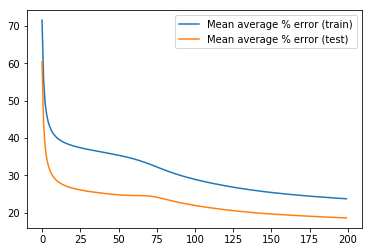

Epoch 210
Loss: 39912.93359375, RMSE: 199.78221130371094, Mean absolute % error: 23.48601531982422
Test loss: 57421.8671875, RMSE: 239.62860107421875, Mean absolute % error: 18.43645477294922


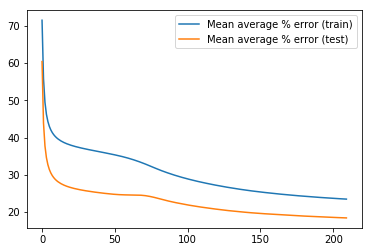

Epoch 220
Loss: 39287.09765625, RMSE: 198.20973205566406, Mean absolute % error: 23.267919540405273
Test loss: 56323.34765625, RMSE: 237.32540893554688, Mean absolute % error: 18.2713565826416


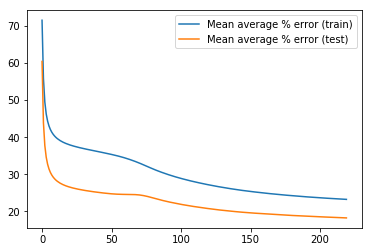

Epoch 230
Loss: 38701.828125, RMSE: 196.72779846191406, Mean absolute % error: 23.056644439697266
Test loss: 55328.03125, RMSE: 235.2191162109375, Mean absolute % error: 18.13036346435547


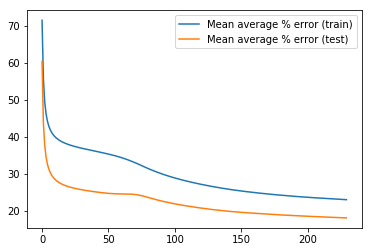

Epoch 240
Loss: 38159.1171875, RMSE: 195.3435821533203, Mean absolute % error: 22.85849952697754
Test loss: 54387.1328125, RMSE: 233.2104949951172, Mean absolute % error: 18.002086639404297


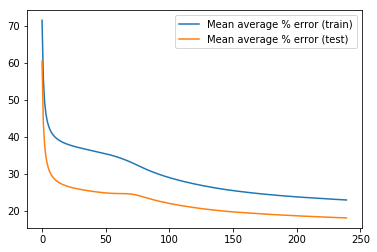

Epoch 250
Loss: 37660.609375, RMSE: 194.06341552734375, Mean absolute % error: 22.679668426513672
Test loss: 53507.7265625, RMSE: 231.31736755371094, Mean absolute % error: 17.89653968811035


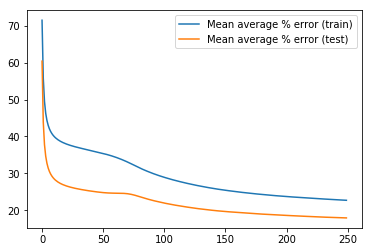

Epoch 260
Loss: 37198.34765625, RMSE: 192.8687286376953, Mean absolute % error: 22.51247215270996
Test loss: 52731.359375, RMSE: 229.6331024169922, Mean absolute % error: 17.795286178588867


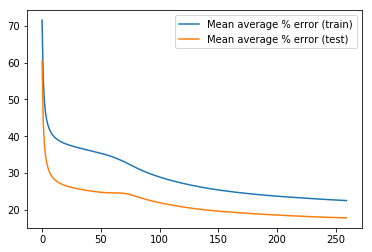

Epoch 270
Loss: 36771.88671875, RMSE: 191.75997924804688, Mean absolute % error: 22.364974975585938
Test loss: 51996.375, RMSE: 228.02713012695312, Mean absolute % error: 17.697322845458984


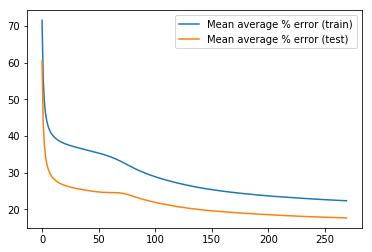

Epoch 280
Loss: 36375.14453125, RMSE: 190.72268676757812, Mean absolute % error: 22.23080825805664
Test loss: 51300.34765625, RMSE: 226.4958038330078, Mean absolute % error: 17.609668731689453


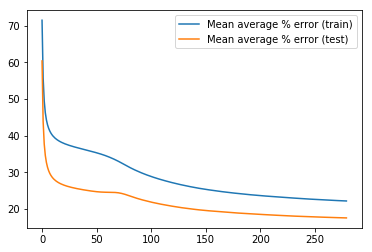

Epoch 290
Loss: 36007.08203125, RMSE: 189.7553253173828, Mean absolute % error: 22.109521865844727
Test loss: 50644.4296875, RMSE: 225.0431671142578, Mean absolute % error: 17.53337860107422


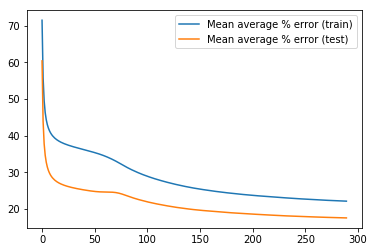

Epoch 300
Loss: 35657.8203125, RMSE: 188.83277893066406, Mean absolute % error: 21.9892635345459
Test loss: 50034.4375, RMSE: 223.6837921142578, Mean absolute % error: 17.451854705810547


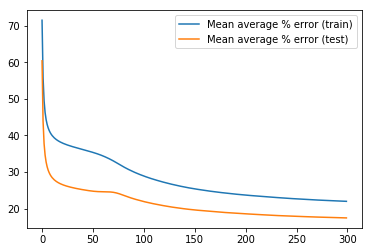

Epoch 310
Loss: 35326.8828125, RMSE: 187.9544677734375, Mean absolute % error: 21.866003036499023
Test loss: 49486.6953125, RMSE: 222.4560546875, Mean absolute % error: 17.366514205932617


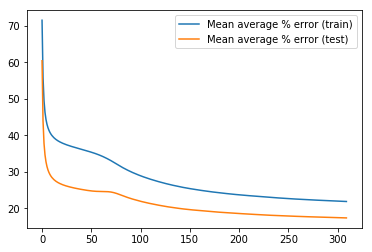

Epoch 320
Loss: 35012.9140625, RMSE: 187.1173858642578, Mean absolute % error: 21.745582580566406
Test loss: 48970.85546875, RMSE: 221.29359436035156, Mean absolute % error: 17.286075592041016


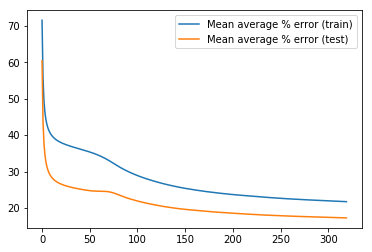

Epoch 330
Loss: 34712.45703125, RMSE: 186.3127899169922, Mean absolute % error: 21.62729835510254
Test loss: 48477.3125, RMSE: 220.17564392089844, Mean absolute % error: 17.21267318725586


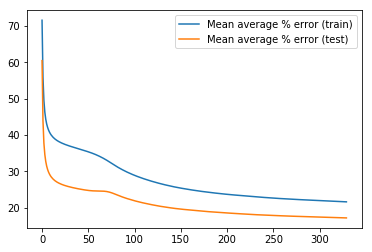

Epoch 340
Loss: 34426.734375, RMSE: 185.54443359375, Mean absolute % error: 21.513446807861328
Test loss: 48004.3984375, RMSE: 219.09906005859375, Mean absolute % error: 17.14258575439453


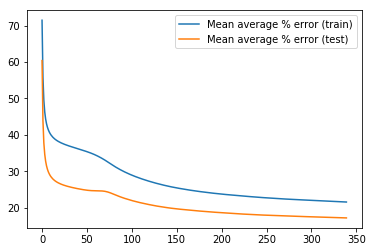

Epoch 350
Loss: 34155.65234375, RMSE: 184.81248474121094, Mean absolute % error: 21.404207229614258
Test loss: 47556.26171875, RMSE: 218.073974609375, Mean absolute % error: 17.076135635375977


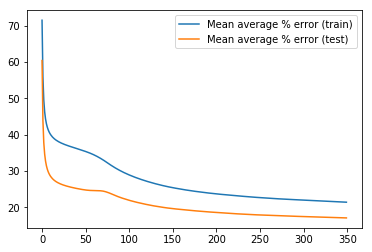

Epoch 360
Loss: 33897.90625, RMSE: 184.1138458251953, Mean absolute % error: 21.299163818359375
Test loss: 47131.50390625, RMSE: 217.09791564941406, Mean absolute % error: 17.0131778717041


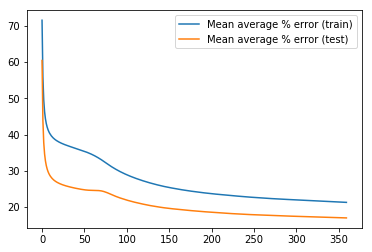

Epoch 370
Loss: 33652.5625, RMSE: 183.44635009765625, Mean absolute % error: 21.198328018188477
Test loss: 46728.04296875, RMSE: 216.1667022705078, Mean absolute % error: 16.95343017578125


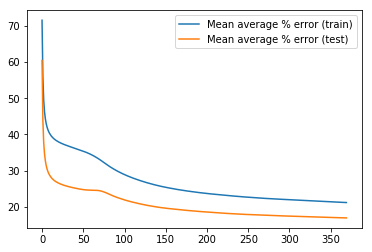

Epoch 380
Loss: 33419.1015625, RMSE: 182.8089141845703, Mean absolute % error: 21.10130500793457
Test loss: 46344.453125, RMSE: 215.27761840820312, Mean absolute % error: 16.896751403808594


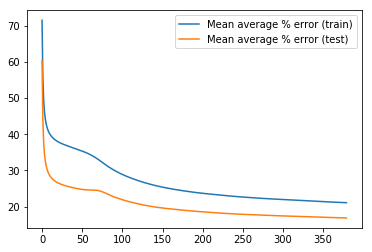

Epoch 390
Loss: 33196.4609375, RMSE: 182.19895935058594, Mean absolute % error: 21.00777244567871
Test loss: 45979.6640625, RMSE: 214.42869567871094, Mean absolute % error: 16.84283447265625


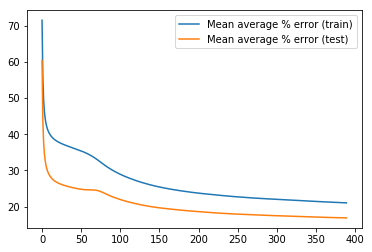

Epoch 400
Loss: 32983.77734375, RMSE: 181.61436462402344, Mean absolute % error: 20.91765785217285
Test loss: 45631.984375, RMSE: 213.61643981933594, Mean absolute % error: 16.791488647460938


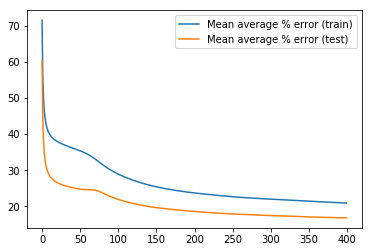

Epoch 410
Loss: 32780.5625, RMSE: 181.0540313720703, Mean absolute % error: 20.830732345581055
Test loss: 45300.24609375, RMSE: 212.8385467529297, Mean absolute % error: 16.742563247680664


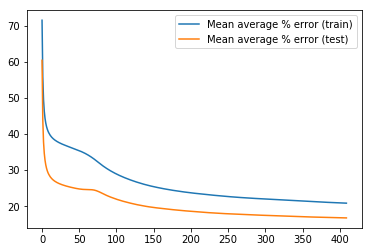

Epoch 420
Loss: 32585.970703125, RMSE: 180.51583862304688, Mean absolute % error: 20.74683380126953
Test loss: 44982.75390625, RMSE: 212.0913848876953, Mean absolute % error: 16.695777893066406


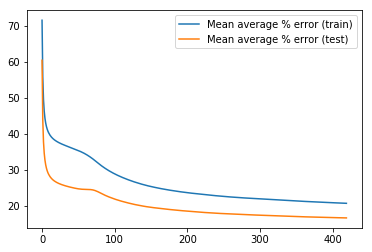

Epoch 430
Loss: 32399.5703125, RMSE: 179.99880981445312, Mean absolute % error: 20.66523551940918
Test loss: 44678.984375, RMSE: 211.37403869628906, Mean absolute % error: 16.65074920654297


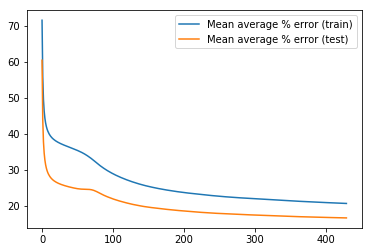

Epoch 440
Loss: 32220.884765625, RMSE: 179.50177001953125, Mean absolute % error: 20.586048126220703
Test loss: 44388.44921875, RMSE: 210.6856689453125, Mean absolute % error: 16.607769012451172


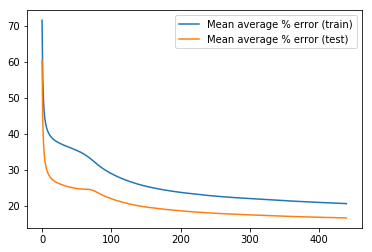

Epoch 450
Loss: 32049.26171875, RMSE: 179.0230712890625, Mean absolute % error: 20.5092830657959
Test loss: 44109.82421875, RMSE: 210.0233917236328, Mean absolute % error: 16.566341400146484


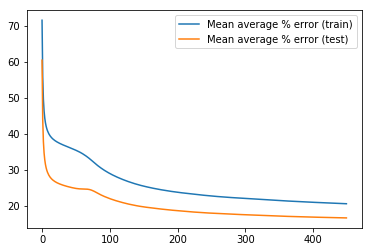

Epoch 460
Loss: 31884.46484375, RMSE: 178.5622100830078, Mean absolute % error: 20.43555450439453
Test loss: 43842.5703125, RMSE: 209.38616943359375, Mean absolute % error: 16.526512145996094


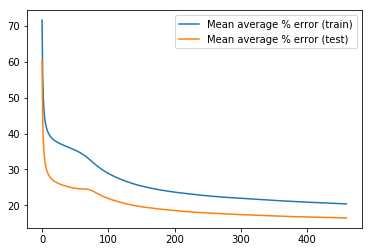

Epoch 470
Loss: 31725.8828125, RMSE: 178.11761474609375, Mean absolute % error: 20.36543846130371
Test loss: 43585.99609375, RMSE: 208.77259826660156, Mean absolute % error: 16.488378524780273


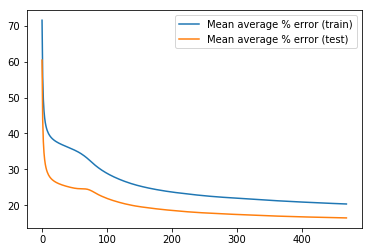

Epoch 480
Loss: 31573.212890625, RMSE: 177.6885223388672, Mean absolute % error: 20.2984619140625
Test loss: 43339.41796875, RMSE: 208.18121337890625, Mean absolute % error: 16.451709747314453


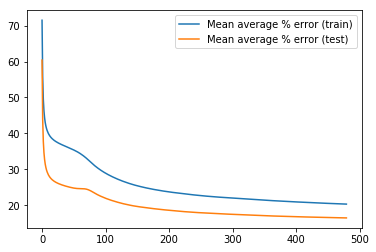

Epoch 490
Loss: 31426.10546875, RMSE: 177.2740936279297, Mean absolute % error: 20.234392166137695
Test loss: 43102.59765625, RMSE: 207.6116485595703, Mean absolute % error: 16.416418075561523


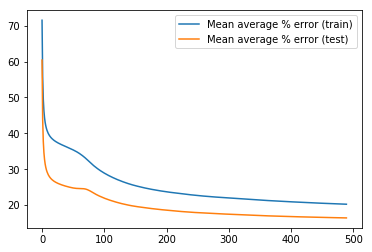

Epoch 500
Loss: 31284.27734375, RMSE: 176.87362670898438, Mean absolute % error: 20.173147201538086
Test loss: 42874.453125, RMSE: 207.0614776611328, Mean absolute % error: 16.382442474365234


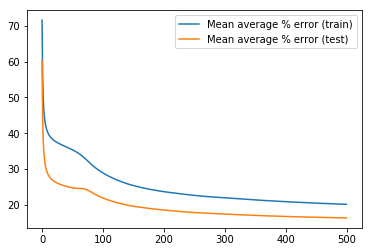

Epoch 510
Loss: 31147.416015625, RMSE: 176.48631286621094, Mean absolute % error: 20.114370346069336
Test loss: 42654.453125, RMSE: 206.529541015625, Mean absolute % error: 16.349576950073242


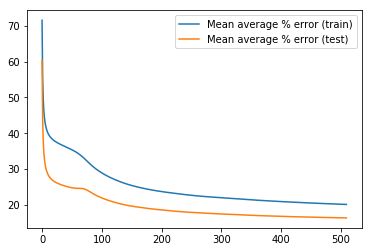

Epoch 520
Loss: 31016.97265625, RMSE: 176.11636352539062, Mean absolute % error: 20.05797576904297
Test loss: 42441.30078125, RMSE: 206.0128631591797, Mean absolute % error: 16.31698989868164


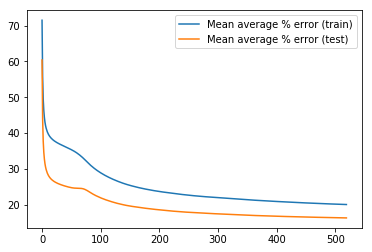

Epoch 530
Loss: 30889.5859375, RMSE: 175.75433349609375, Mean absolute % error: 20.003833770751953
Test loss: 42237.44140625, RMSE: 205.5175018310547, Mean absolute % error: 16.28659439086914


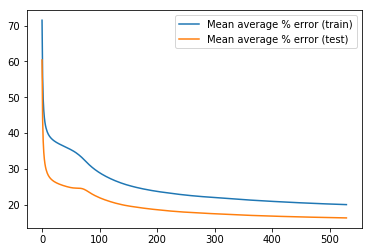

Epoch 540
Loss: 30766.451171875, RMSE: 175.4036865234375, Mean absolute % error: 19.9517822265625
Test loss: 42040.5625, RMSE: 205.03794860839844, Mean absolute % error: 16.257164001464844


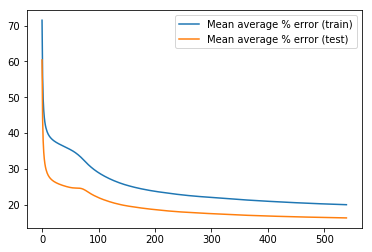

Epoch 550
Loss: 30647.1484375, RMSE: 175.06326293945312, Mean absolute % error: 19.90178871154785
Test loss: 41850.34375, RMSE: 204.5735626220703, Mean absolute % error: 16.228662490844727


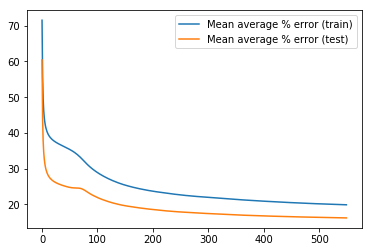

Epoch 560
Loss: 30531.51171875, RMSE: 174.73268127441406, Mean absolute % error: 19.853456497192383
Test loss: 41666.453125, RMSE: 204.12362670898438, Mean absolute % error: 16.200889587402344


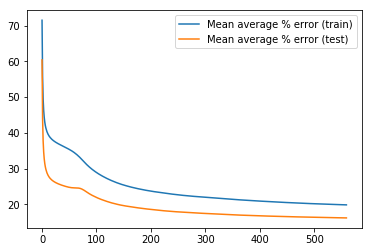

Epoch 570
Loss: 30419.693359375, RMSE: 174.4124298095703, Mean absolute % error: 19.806591033935547
Test loss: 41489.04296875, RMSE: 203.6885986328125, Mean absolute % error: 16.173995971679688


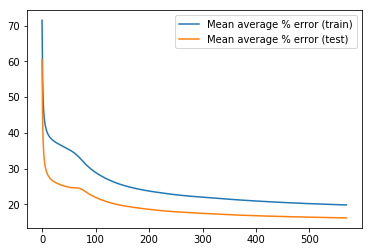

Epoch 580
Loss: 30310.947265625, RMSE: 174.1003875732422, Mean absolute % error: 19.761693954467773
Test loss: 41316.73828125, RMSE: 203.26519775390625, Mean absolute % error: 16.147903442382812


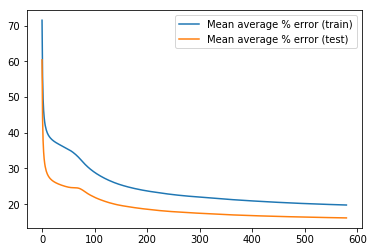

Epoch 590
Loss: 30205.1796875, RMSE: 173.79637145996094, Mean absolute % error: 19.71871566772461
Test loss: 41148.875, RMSE: 202.8518524169922, Mean absolute % error: 16.123140335083008


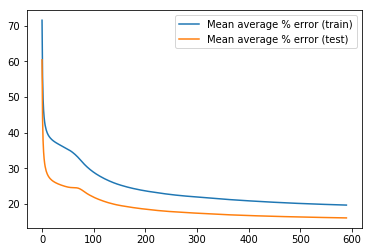

Epoch 600
Loss: 30102.642578125, RMSE: 173.50112915039062, Mean absolute % error: 19.67708396911621
Test loss: 40986.375, RMSE: 202.45091247558594, Mean absolute % error: 16.099111557006836


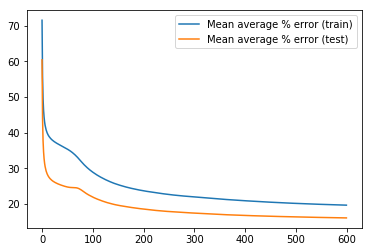

Epoch 610
Loss: 30003.166015625, RMSE: 173.21421813964844, Mean absolute % error: 19.636877059936523
Test loss: 40828.84765625, RMSE: 202.06149291992188, Mean absolute % error: 16.075815200805664


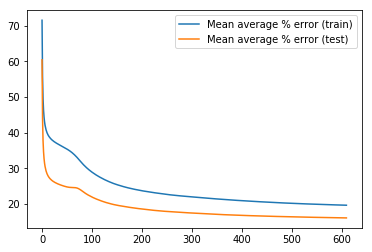

Epoch 620
Loss: 29906.541015625, RMSE: 172.93507385253906, Mean absolute % error: 19.59764862060547
Test loss: 40676.53515625, RMSE: 201.6842498779297, Mean absolute % error: 16.053050994873047


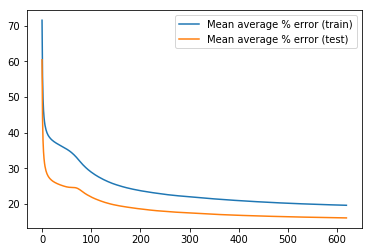

Epoch 630
Loss: 29812.73046875, RMSE: 172.66363525390625, Mean absolute % error: 19.559627532958984
Test loss: 40528.953125, RMSE: 201.3180389404297, Mean absolute % error: 16.03091812133789


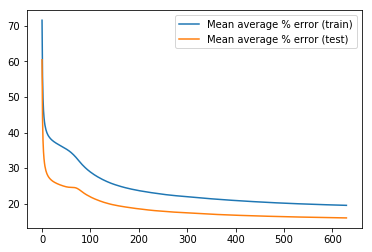

Epoch 640
Loss: 29721.66015625, RMSE: 172.3997039794922, Mean absolute % error: 19.522592544555664
Test loss: 40385.6796875, RMSE: 200.96188354492188, Mean absolute % error: 16.009248733520508


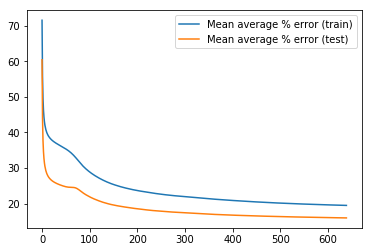

Epoch 650
Loss: 29632.861328125, RMSE: 172.14198303222656, Mean absolute % error: 19.486528396606445
Test loss: 40246.875, RMSE: 200.61624145507812, Mean absolute % error: 15.98801040649414


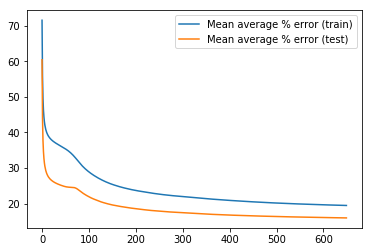

Epoch 660
Loss: 29546.705078125, RMSE: 171.8915557861328, Mean absolute % error: 19.451457977294922
Test loss: 40112.0703125, RMSE: 200.2799835205078, Mean absolute % error: 15.967327117919922


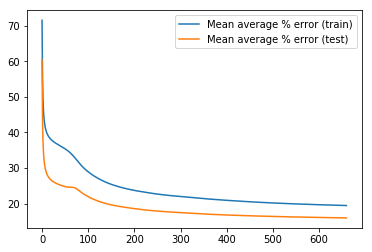

Epoch 670
Loss: 29462.984375, RMSE: 171.64784240722656, Mean absolute % error: 19.41741371154785
Test loss: 39981.4453125, RMSE: 199.95361328125, Mean absolute % error: 15.947251319885254


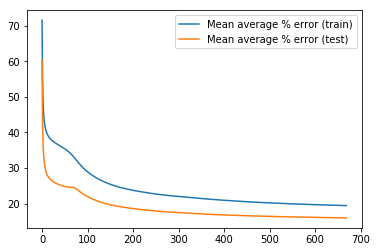

Epoch 680
Loss: 29381.4453125, RMSE: 171.41017150878906, Mean absolute % error: 19.384016036987305
Test loss: 39854.640625, RMSE: 199.6362762451172, Mean absolute % error: 15.927395820617676


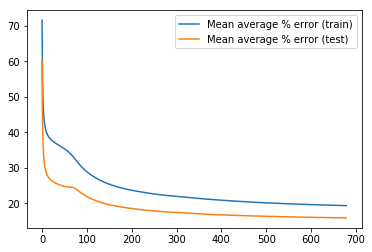

Epoch 690
Loss: 29302.091796875, RMSE: 171.1785430908203, Mean absolute % error: 19.351465225219727
Test loss: 39731.64453125, RMSE: 199.32798767089844, Mean absolute % error: 15.908064842224121


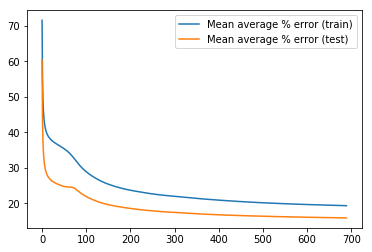

Epoch 700
Loss: 29224.74609375, RMSE: 170.9524688720703, Mean absolute % error: 19.32001495361328
Test loss: 39612.00390625, RMSE: 199.02764892578125, Mean absolute % error: 15.889276504516602


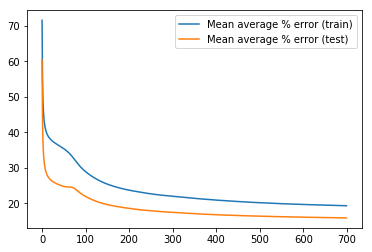

Epoch 710
Loss: 29149.439453125, RMSE: 170.73207092285156, Mean absolute % error: 19.28919219970703
Test loss: 39495.80078125, RMSE: 198.73550415039062, Mean absolute % error: 15.870794296264648


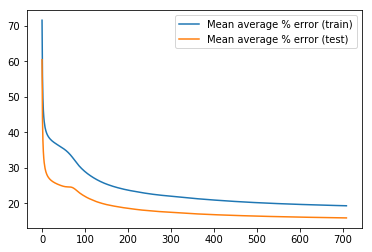

Epoch 720
Loss: 29076.0390625, RMSE: 170.51698303222656, Mean absolute % error: 19.259180068969727
Test loss: 39382.73828125, RMSE: 198.4508514404297, Mean absolute % error: 15.85267162322998


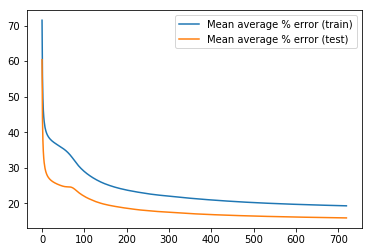

Epoch 730
Loss: 29004.46484375, RMSE: 170.30697631835938, Mean absolute % error: 19.229955673217773
Test loss: 39272.55859375, RMSE: 198.1730499267578, Mean absolute % error: 15.834895133972168


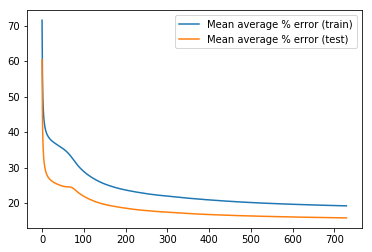

Epoch 740
Loss: 28934.64453125, RMSE: 170.10186767578125, Mean absolute % error: 19.201398849487305
Test loss: 39165.25390625, RMSE: 197.90213012695312, Mean absolute % error: 15.81739330291748


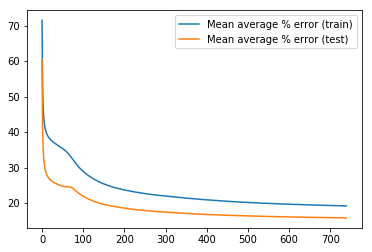

Epoch 750
Loss: 28866.501953125, RMSE: 169.9014434814453, Mean absolute % error: 19.17359733581543
Test loss: 39060.64453125, RMSE: 197.63766479492188, Mean absolute % error: 15.800216674804688


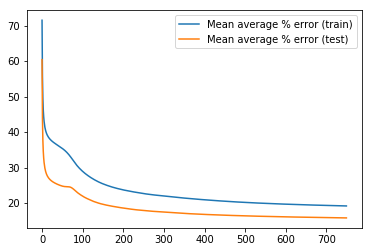

Epoch 760
Loss: 28799.95703125, RMSE: 169.70550537109375, Mean absolute % error: 19.146488189697266
Test loss: 38958.66015625, RMSE: 197.37948608398438, Mean absolute % error: 15.783313751220703


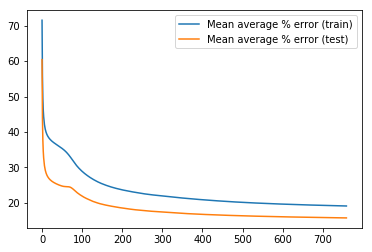

Epoch 770
Loss: 28735.005859375, RMSE: 169.51402282714844, Mean absolute % error: 19.11977195739746
Test loss: 38859.28125, RMSE: 197.12757873535156, Mean absolute % error: 15.76654052734375


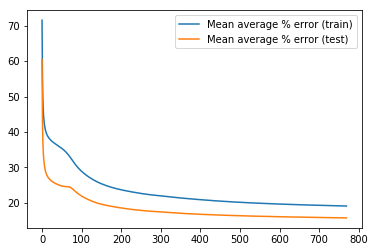

Epoch 780
Loss: 28671.64453125, RMSE: 169.32704162597656, Mean absolute % error: 19.093412399291992
Test loss: 38762.89453125, RMSE: 196.88294982910156, Mean absolute % error: 15.749969482421875


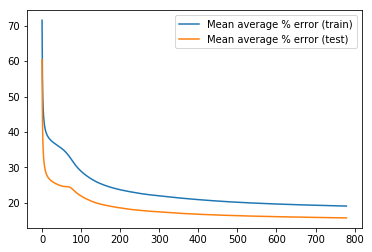

Epoch 790
Loss: 28609.744140625, RMSE: 169.14414978027344, Mean absolute % error: 19.06773567199707
Test loss: 38669.0546875, RMSE: 196.6444854736328, Mean absolute % error: 15.733687400817871


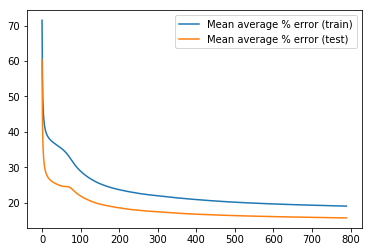

Epoch 800
Loss: 28549.208984375, RMSE: 168.96511840820312, Mean absolute % error: 19.042665481567383
Test loss: 38577.50390625, RMSE: 196.41156005859375, Mean absolute % error: 15.717609405517578


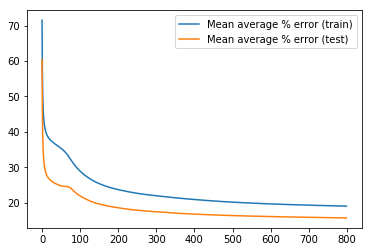

Epoch 810
Loss: 28490.060546875, RMSE: 168.7899932861328, Mean absolute % error: 19.01818084716797
Test loss: 38488.0234375, RMSE: 196.18365478515625, Mean absolute % error: 15.701767921447754


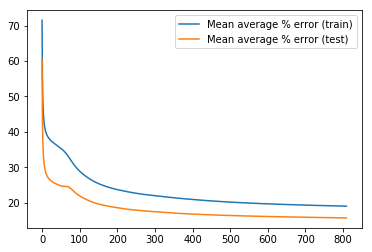

Epoch 820
Loss: 28432.21484375, RMSE: 168.61854553222656, Mean absolute % error: 18.99432373046875
Test loss: 38400.5625, RMSE: 195.9606170654297, Mean absolute % error: 15.68616771697998


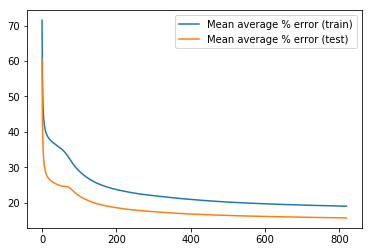

Epoch 830
Loss: 28375.623046875, RMSE: 168.45065307617188, Mean absolute % error: 18.97101593017578
Test loss: 38315.125, RMSE: 195.74249267578125, Mean absolute % error: 15.670753479003906


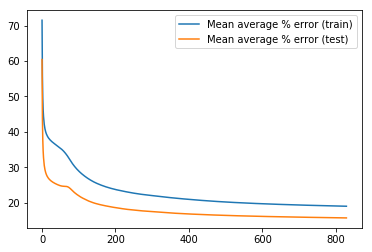

Epoch 840
Loss: 28320.25, RMSE: 168.2862091064453, Mean absolute % error: 18.948184967041016
Test loss: 38231.63671875, RMSE: 195.52911376953125, Mean absolute % error: 15.655515670776367


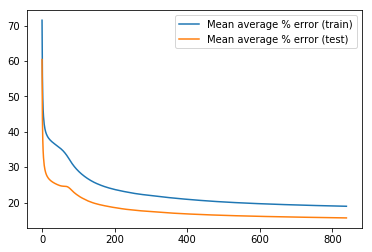

Epoch 850
Loss: 28266.05859375, RMSE: 168.1251220703125, Mean absolute % error: 18.925947189331055
Test loss: 38149.9609375, RMSE: 195.3201446533203, Mean absolute % error: 15.640480041503906


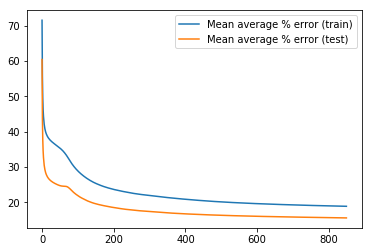

Epoch 860
Loss: 28212.994140625, RMSE: 167.9672393798828, Mean absolute % error: 18.90422821044922
Test loss: 38070.0546875, RMSE: 195.11549377441406, Mean absolute % error: 15.625592231750488


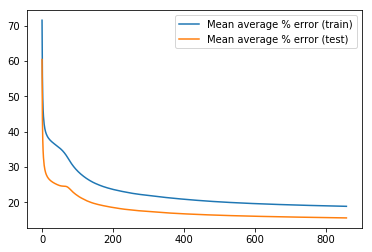

Epoch 870
Loss: 28161.029296875, RMSE: 167.81248474121094, Mean absolute % error: 18.882949829101562
Test loss: 37991.8671875, RMSE: 194.91502380371094, Mean absolute % error: 15.610865592956543


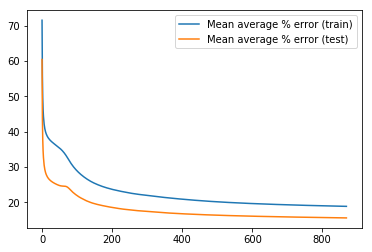

Epoch 880
Loss: 28110.1328125, RMSE: 167.6607666015625, Mean absolute % error: 18.862194061279297
Test loss: 37915.35546875, RMSE: 194.71865844726562, Mean absolute % error: 15.59631061553955


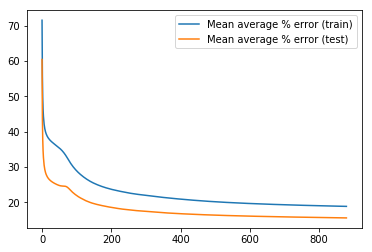

Epoch 890
Loss: 28060.2890625, RMSE: 167.51205444335938, Mean absolute % error: 18.841894149780273
Test loss: 37840.44921875, RMSE: 194.52621459960938, Mean absolute % error: 15.581904411315918


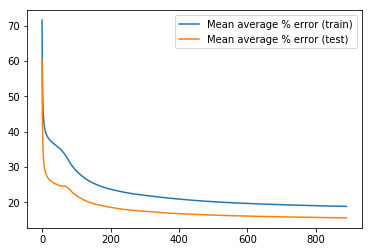

Epoch 900
Loss: 28011.439453125, RMSE: 167.36618041992188, Mean absolute % error: 18.821989059448242
Test loss: 37767.08984375, RMSE: 194.3375701904297, Mean absolute % error: 15.567581176757812


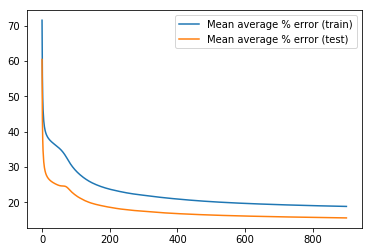

Epoch 910
Loss: 27963.552734375, RMSE: 167.2230682373047, Mean absolute % error: 18.802593231201172
Test loss: 37695.17578125, RMSE: 194.15245056152344, Mean absolute % error: 15.553400993347168


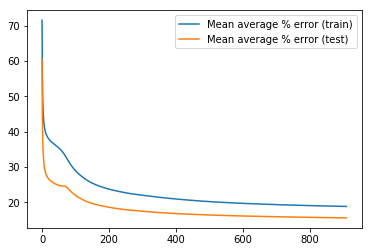

Epoch 920
Loss: 27916.583984375, RMSE: 167.0825653076172, Mean absolute % error: 18.783588409423828
Test loss: 37624.8359375, RMSE: 193.97122192382812, Mean absolute % error: 15.539338111877441


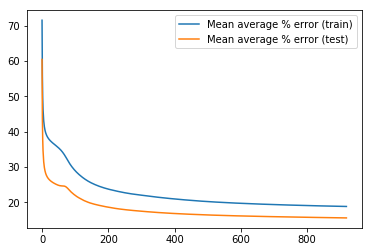

Epoch 930
Loss: 27870.5703125, RMSE: 166.94480895996094, Mean absolute % error: 18.7650146484375
Test loss: 37555.91796875, RMSE: 193.79348754882812, Mean absolute % error: 15.525391578674316


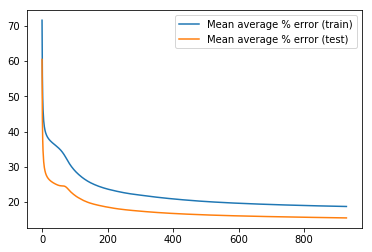

Epoch 940
Loss: 27825.41015625, RMSE: 166.80950927734375, Mean absolute % error: 18.74694061279297
Test loss: 37488.34375, RMSE: 193.6190643310547, Mean absolute % error: 15.511550903320312


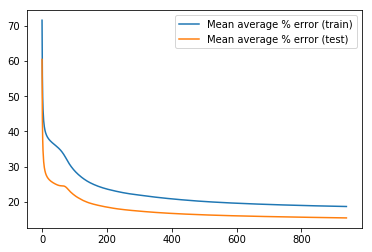

Epoch 950
Loss: 27781.1796875, RMSE: 166.67686462402344, Mean absolute % error: 18.729225158691406
Test loss: 37422.1328125, RMSE: 193.44801330566406, Mean absolute % error: 15.497748374938965


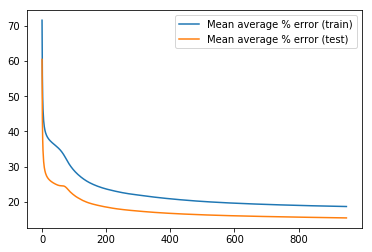

Epoch 960
Loss: 27737.775390625, RMSE: 166.54661560058594, Mean absolute % error: 18.711959838867188
Test loss: 37357.19921875, RMSE: 193.2801055908203, Mean absolute % error: 15.484089851379395


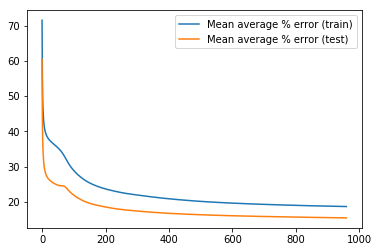

Epoch 970
Loss: 27695.140625, RMSE: 166.41856384277344, Mean absolute % error: 18.695037841796875
Test loss: 37293.52734375, RMSE: 193.11532592773438, Mean absolute % error: 15.470457077026367


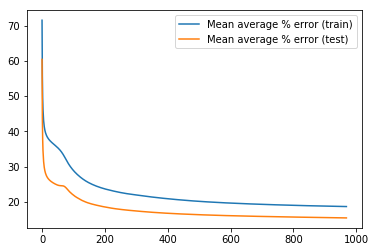

Epoch 980
Loss: 27653.240234375, RMSE: 166.29263305664062, Mean absolute % error: 18.678510665893555
Test loss: 37230.94140625, RMSE: 192.95321655273438, Mean absolute % error: 15.456888198852539


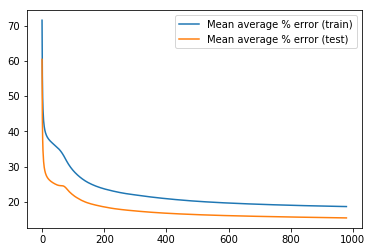

Epoch 990
Loss: 27611.978515625, RMSE: 166.16851806640625, Mean absolute % error: 18.662342071533203
Test loss: 37169.1015625, RMSE: 192.7928924560547, Mean absolute % error: 15.443328857421875


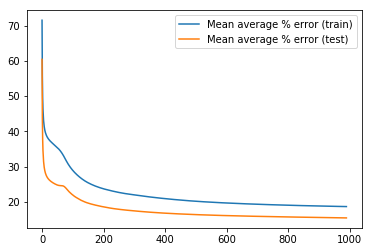

Epoch 1000
Loss: 27571.556640625, RMSE: 166.04684448242188, Mean absolute % error: 18.646522521972656
Test loss: 37108.6015625, RMSE: 192.63592529296875, Mean absolute % error: 15.429924964904785


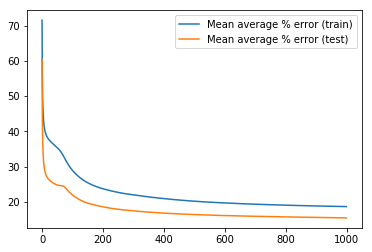

In [18]:
# will be slow unless you're on a GPU :'(
train_rmses, train_mapes, test_rmses, test_mapes = [], [], [], []

log_step = 10

for epoch in range(N_EPOCHS):
    
    for x, y in data_train:
        train_step(np.array([x]), np.array([y]))

    for x, y in data_test:
        test_step(np.array([x]), np.array([y]))
        
    train_rmses.append(np.sqrt(train_mse.result()))
    test_rmses.append(np.sqrt(test_mse.result()))
    train_mapes.append(train_mape.result())
    test_mapes.append(test_mape.result())
    
    if (epoch+1) % log_step == 0:
        template = ('Epoch {}\n'
                    'Loss: {}, RMSE: {}, Mean absolute % error: {}\n'
                    'Test loss: {}, RMSE: {}, Mean absolute % error: {}')
        print(template.format(epoch+1,
                             train_loss.result(), 
                             train_rmses[-1],
                             train_mapes[-1],
                             test_loss.result(), 
                             test_rmses[-1],
                             test_mapes[-1]))
        
        plt.figure()
        plt.plot(train_mapes, label='Mean average % error (train)')
        plt.plot(test_mapes, label='Mean average % error (test)')
        plt.legend()
        plt.show()

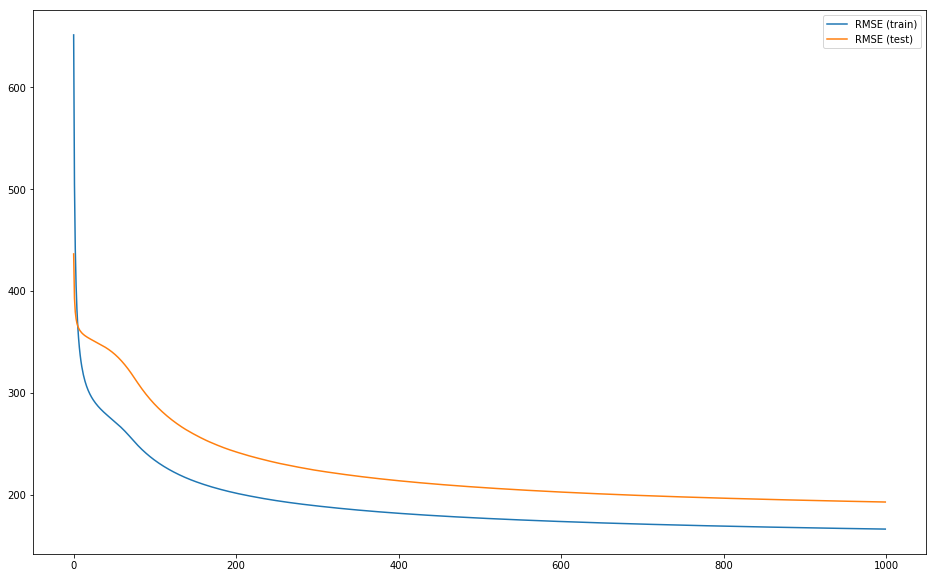

In [19]:
plt.figure(figsize=(16,10))
plt.plot(train_rmses, label='RMSE (train)')
plt.plot(test_rmses, label='RMSE (test)')
plt.legend()
plt.show()

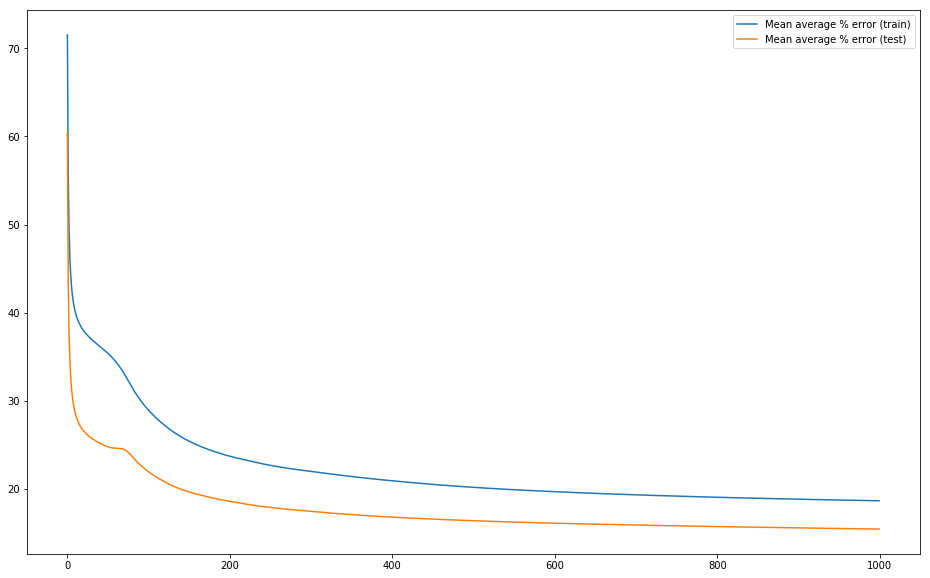

In [20]:
plt.figure(figsize=(16,10))
plt.plot(train_mapes, label='Mean average % error (train)')
plt.plot(test_mapes, label='Mean average % error (test)')
plt.legend()
plt.show()

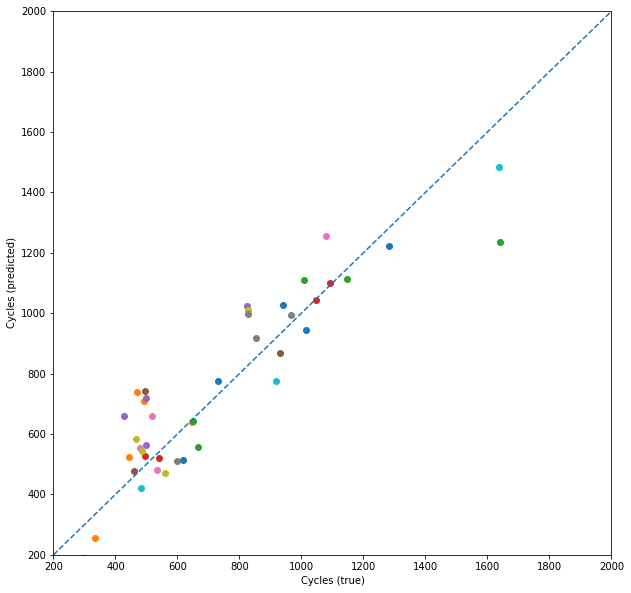

In [21]:
plt.figure(figsize=(10,10))


for x, y_true in data_val[:100]:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred)

lim_min, lim_max = 200, 2000

plt.ylabel('Cycles (predicted)')
plt.xlabel('Cycles (true)')
plt.axis([lim_min, lim_max, lim_min, lim_max])
plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='--')
plt.show()